# DATA ANALYSIS - CLUSTER EXAMINATION

`Author: José Luis Maldonado Álvarez`

## PAM (Partitioning Around Medoids)

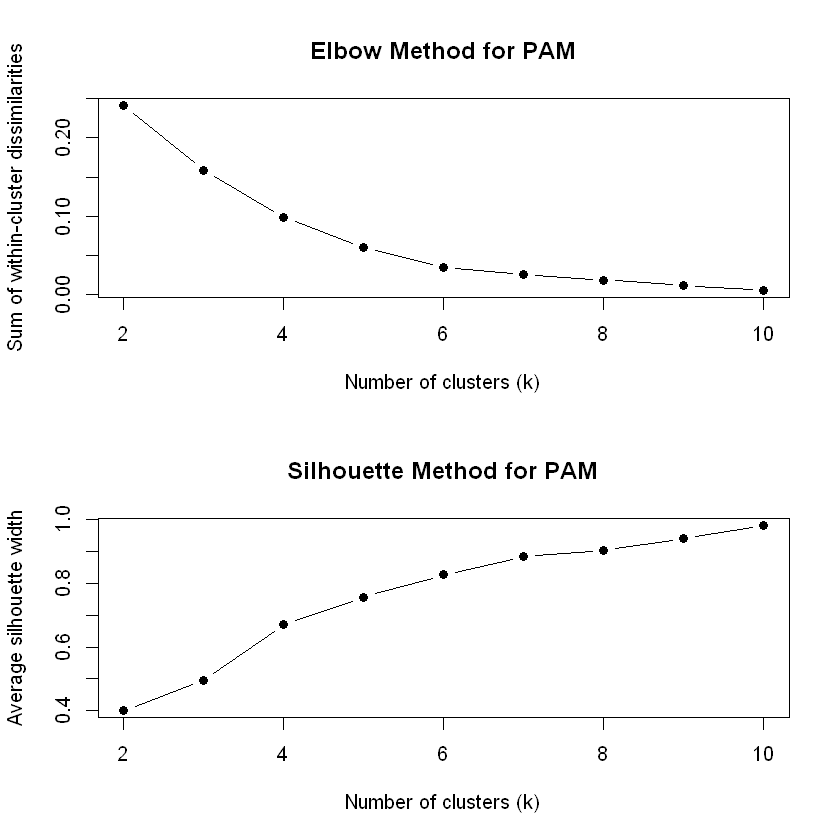

In [1]:
suppressPackageStartupMessages(library(cluster))
suppressPackageStartupMessages(library(dplyr))

# Load data and select only variables that start with 'SE_'
df <- read.csv('FINAL_DATASET.csv')
se_vars <- df %>%
    select(c(SE_INT, SE_STU, SE_HI)) %>%
    mutate(across(everything(), as.factor)) # %>%
    # select(starts_with("SE_")) %>%
    # select(-c(SE_GCHI, SE_CHI, SE_LA, SE_SN, SE_PC, SE_MP, SE_WT, SE_PUBT, SE_PI, SE_PRIT))

# Determine the optimal number of clusters for k-means using the elbow and silhouette methods
# set.seed(123)
# Compute the dissimilarity matrix using daisy (already done above)
diss <- daisy(se_vars, metric = "gower")

# Elbow method: compute total within-cluster dissimilarity for k = 2 to 10
wss <- numeric(9)
sil_width <- numeric(9)
for (k in 2:10) {
    pam_fit <- pam(diss, k, diss = TRUE)
    wss[k - 1] <- pam_fit$objective[1]
    sil_width[k - 1] <- pam_fit$silinfo$avg.width
}

# Plot elbow method
par(bg = "white", mfrow = c(2, 1))
plot(2:10, wss, type = "b", pch = 19, xlab = "Number of clusters (k)", ylab = "Sum of within-cluster dissimilarities",
    main = "Elbow Method for PAM")

# Plot silhouette method
plot(2:10, sil_width, type = "b", pch = 19, xlab = "Number of clusters (k)", ylab = "Average silhouette width",
    main = "Silhouette Method for PAM")


In [2]:
# PAM (Partitioning Around Medoids) clustering using Gower distance
set.seed(123)
k <- 4
pam_result <- pam(diss, k)

# Add cluster assignment to the data
se_vars$cluster_pam <- as.factor(pam_result$clustering)

# # Visualize clusters using first two principal coordinates
# pc <- cmdscale(diss, k = 2)
# par(bg = "white")
# plot(pc, col = se_vars$cluster_pam, pch = 19, main = "PAM Clusters (SE_ variables, Gower distance)")
# legend("topright", legend = levels(se_vars$cluster_pam), col = 1:k, pch = 19)

# # Analyze the characteristics of each cluster
# cluster_summary_pam <- se_vars %>%
#     group_by(cluster_pam) %>%
#     summarise(across(where(is.factor), ~paste0(names(sort(table(.), decreasing = TRUE)[1]), " (", max(table(.)), ")"), .names = "mode_{.col}"),
#               count = n())

# print(cluster_summary_pam)

# Show the distribution of each SE_ variable by cluster
for (var in names(se_vars)[names(se_vars) != "cluster_pam"]) {
    cat("\nVariable:", var, "\n")
    print(table(se_vars[[var]], se_vars$cluster_pam))
}

# Print the distribution of OUT_MACE variable for each cluster from pam_result
cat("\nMACE distribution by PAM clusters:")
mace_by_pam_cluster <- table(df$OUT_MACE, se_vars$cluster_pam)
print(mace_by_pam_cluster)

# Calculate and print percentage of OUT_MACE == 1 for each cluster
cat("\nMACE percentage of occurence by PAM clusters:\n")
percent_mace1 <- prop.table(mace_by_pam_cluster, 2)["1", ] * 100
print(round(percent_mace1, 2))


Variable: SE_INT 
   
      1   2   3   4
  0  38 163 241  38
  1 386 347 458 438

Variable: SE_STU 
   
      1   2   3   4
  1   0 510 699   0
  2 424   0   0 476

Variable: SE_HI 
                  
                     1   2   3   4
  (30707,34138.7]  379   0 599   0
  (34138.7, 76251]   0 510   0 476
  [25649,30707]     45   0 100   0

MACE distribution by PAM clusters:   
      1   2   3   4
  0 353 399 549 403
  1  71 111 150  73

MACE percentage of occurence by PAM clusters:
    1     2     3     4 
16.75 21.76 21.46 15.34 


Warning message:
"package 'fmsb' was built under R version 4.4.3"
Warning message:
"Setting row names on a tibble is deprecated."


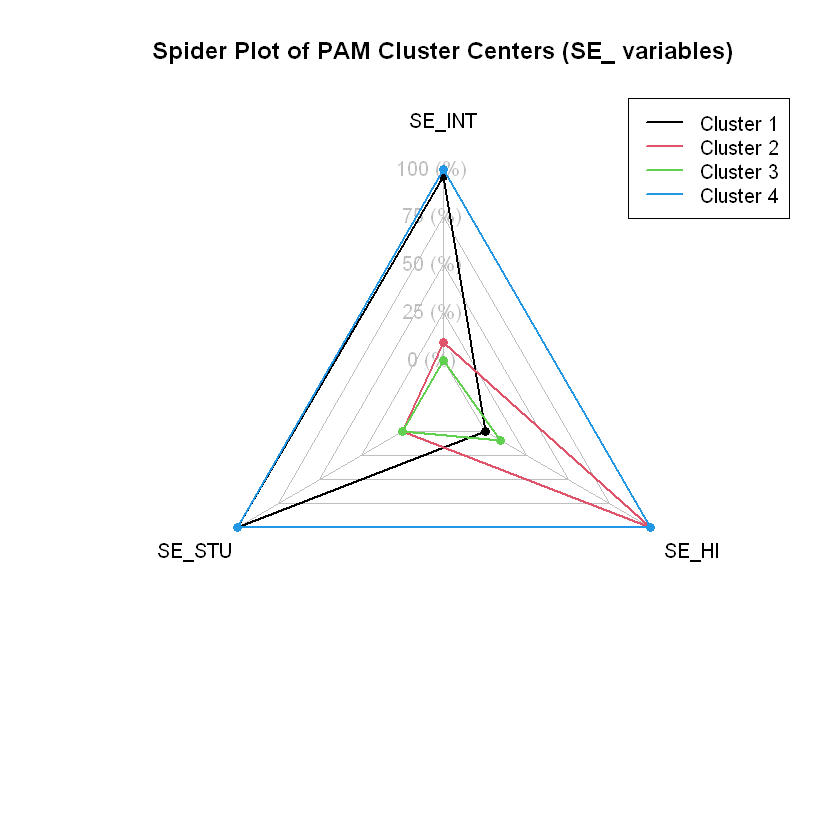

In [3]:
# Spider (radar) plot of cluster centers from pam_result
suppressPackageStartupMessages(library(fmsb))

# Prepare data: convert factors to numeric for radar plot
se_numeric_pam <- se_vars %>%
    select(-cluster_pam) %>%
    mutate(across(everything(), ~as.numeric(as.factor(.))))

cluster_centers_pam <- se_numeric_pam %>%
    mutate(cluster_pam = pam_result$clustering) %>%
    group_by(cluster_pam) %>%
    summarise(across(everything(), mean))

# fmsb requires max/min rows
max_vals_pam <- apply(cluster_centers_pam[,-1], 2, max)
min_vals_pam <- apply(cluster_centers_pam[,-1], 2, min)
radar_data_pam <- rbind(max_vals_pam, min_vals_pam, cluster_centers_pam[,-1])

# Set row names for clarity
rownames(radar_data_pam) <- c("Max", "Min", paste0("Cluster_", cluster_centers_pam$cluster_pam))

# Plot
par(bg = "white")
radarchart(radar_data_pam, axistype = 1,
           title = "Spider Plot of PAM Cluster Centers (SE_ variables)",
           pcol = 1:k, plwd = 2, plty = 1, cglcol = "grey", cglty = 1, axislabcol = "grey")
legend("topright", legend = paste0("Cluster ", cluster_centers_pam$cluster_pam), col = 1:k, lty = 1, lwd = 2)

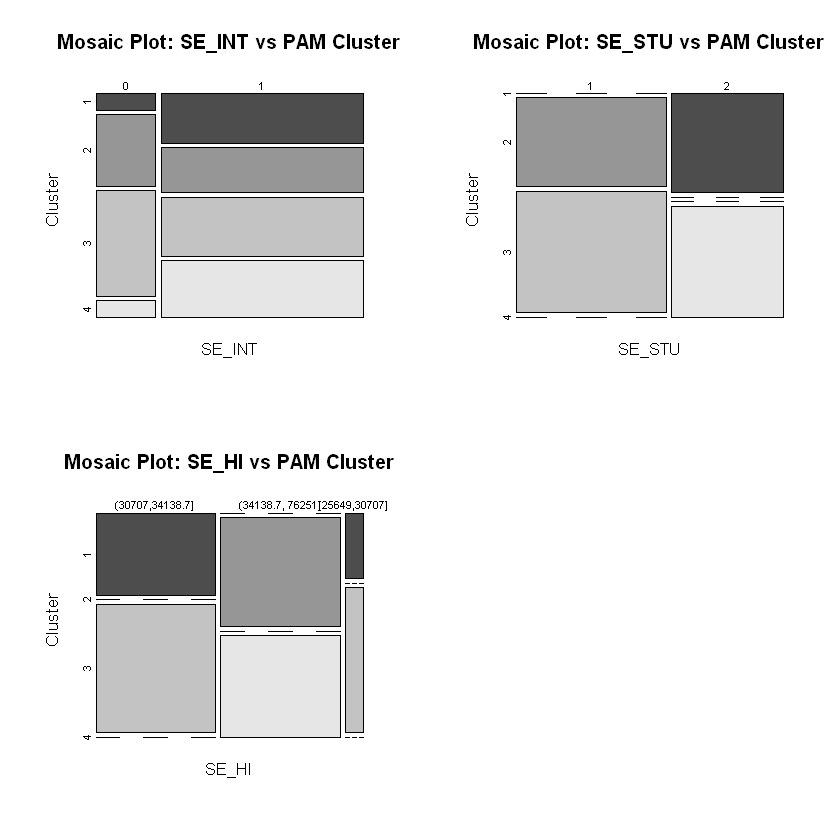

In [4]:
par(bg = "white", mfrow = c(2, 2))
# Mosaic plot for SE_INT vs cluster_pam
mosaicplot(table(se_vars$SE_INT, se_vars$cluster_pam),
           main = "Mosaic Plot: SE_INT vs PAM Cluster",
           xlab = "SE_INT", ylab = "Cluster", color = TRUE)
# Mosaic plot for SE_STU vs cluster_pam
mosaicplot(table(se_vars$SE_STU, se_vars$cluster_pam),
           main = "Mosaic Plot: SE_STU vs PAM Cluster",
           xlab = "SE_STU", ylab = "Cluster", color = TRUE)
# Mosaic plot for SE_HI vs cluster_pam
mosaicplot(table(se_vars$SE_HI, se_vars$cluster_pam),
           main = "Mosaic Plot: SE_HI vs PAM Cluster",
           xlab = "SE_HI", ylab = "Cluster", color = TRUE)

In [5]:
str(se_vars)
cluster_pam <- se_vars$cluster_pam

'data.frame':	2109 obs. of  4 variables:
 $ SE_INT     : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SE_STU     : Factor w/ 2 levels "1","2": 2 1 2 1 1 1 1 1 2 1 ...
 $ SE_HI      : Factor w/ 3 levels "(30707,34138.7]",..: 1 2 1 1 2 2 1 1 2 3 ...
 $ cluster_pam: Factor w/ 4 levels "1","2","3","4": 1 2 1 3 2 2 3 3 4 3 ...


# KMEANS

Warning message:
"package 'klaR' was built under R version 4.4.2"


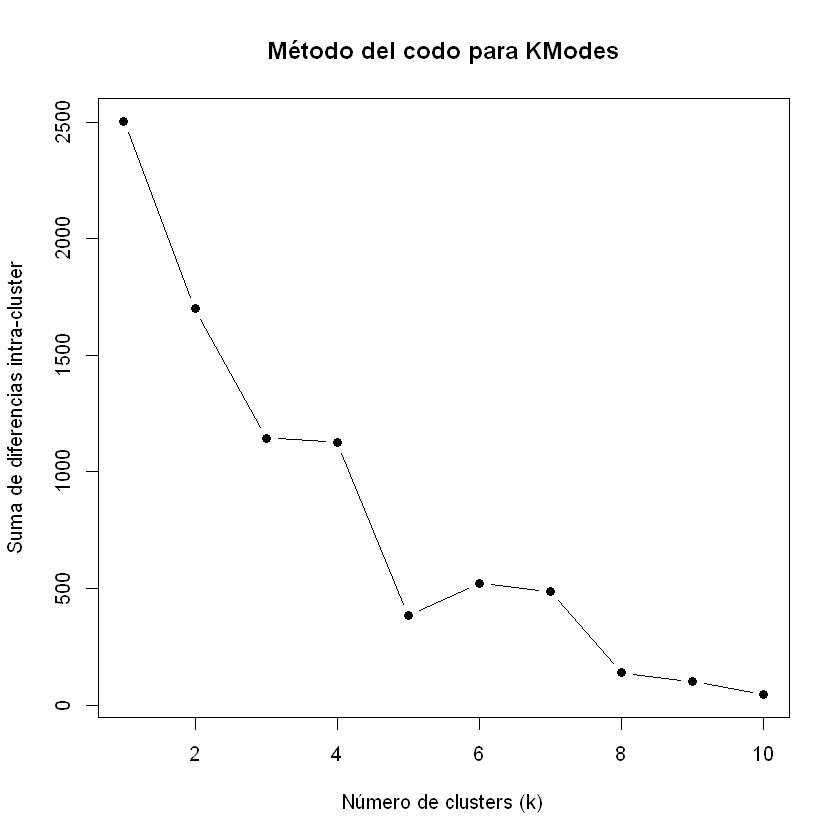

In [6]:
# KModes clustering for categorical data
suppressPackageStartupMessages(library(cluster))
suppressPackageStartupMessages(library(dplyr))

# Load data and select only variables that start with 'SE_'
df <- read.csv('FINAL_DATASET.csv')
se_vars <- df %>%
    select(c(SE_INT, SE_STU, SE_HI)) %>%
    mutate(across(everything(), as.factor)) #%>%
    # select(starts_with("SE_")) %>%
    # select(-c(SE_GCHI, SE_CHI, SE_LA, SE_SN, SE_PC, SE_MP, SE_WT, SE_PUBT, SE_PI, SE_PRIT))

# Prepare data: se_vars already contains only factor variables (excluding cluster assignments)
# Remove any cluster columns if present
se_vars_kmodes <- se_vars %>%
    select(-matches("^cluster"))

suppressPackageStartupMessages(library(klaR))

set.seed(123)
max_k <- 10
withindiff_vec <- numeric(max_k)

for (k in 1:max_k) {
    km_res <- suppressWarnings(kmodes(se_vars_kmodes, modes = k, iter.max = 20))
    withindiff_vec[k] <- sum(km_res$withindiff)
}
par(bg = "white")
plot(1:max_k, withindiff_vec, type = "b", pch = 19,
     xlab = "Número de clusters (k)", ylab = "Suma de diferencias intra-cluster",
     main = "Método del codo para KModes")


In [7]:
set.seed(123)
k <- 3
kmodes_result <- kmodes(se_vars_kmodes, modes = k, iter.max = 20)

# Add cluster assignment to the data
se_vars$cluster_kmodes <- as.factor(kmodes_result$cluster)

# Show the distribution of each SE_ variable by cluster
for (var in names(se_vars)[names(se_vars) != "cluster_kmodes"]) {
    cat("\nVariable:", var, "\n")
    print(table(se_vars[[var]], se_vars$cluster_kmodes))
}

# Print the distribution of OUT_MACE variable for each KModes cluster
cat("\nMACE distribution by KModes clusters:")
mace_by_kmodes_cluster <- table(df$OUT_MACE, se_vars$cluster_kmodes)
print(mace_by_kmodes_cluster)

# Calculate and print percentage of OUT_MACE == 1 for each cluster
cat("\nMACE percentage of occurence by Kmodes clusters:\n")
percent_mace_kmodes <- prop.table(mace_by_kmodes_cluster, 2)["1", ] * 100
print(round(percent_mace_kmodes, 2))



Variable: SE_INT 
   
      1   2   3
  0 105  33 342
  1 726 782 121

Variable: SE_STU 
   
      1   2   3
  1 649 125 435
  2 182 690  28

Variable: SE_HI 
                  
                     1   2   3
  (30707,34138.7]  674 187 117
  (34138.7, 76251] 101 584 301
  [25649,30707]     56  44  45

MACE distribution by KModes clusters:   
      1   2   3
  0 675 691 338
  1 156 124 125

MACE percentage of occurence by Kmodes clusters:
    1     2     3 
18.77 15.21 27.00 


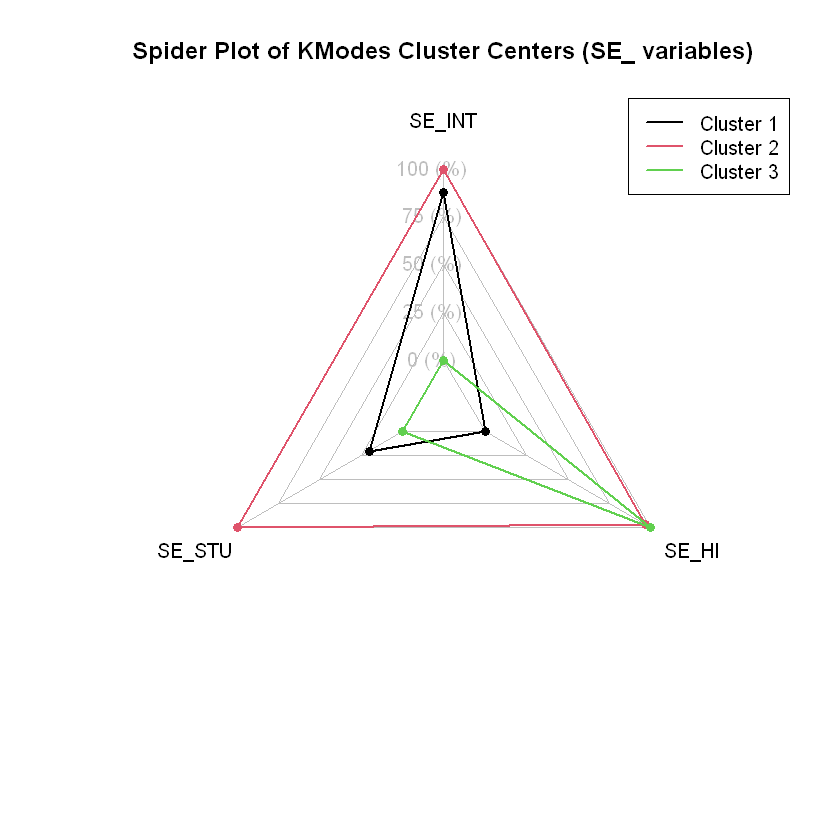

In [8]:
# Spider (radar) plot of cluster centers from KModes clustering
suppressPackageStartupMessages(library(fmsb))

# Prepare data: convert factors to numeric for radar plot
se_numeric_kmodes <- se_vars
se_numeric_kmodes$cluster_kmodes <- as.factor(se_numeric_kmodes$cluster_kmodes)
for (col in names(se_numeric_kmodes)[names(se_numeric_kmodes) != "cluster_kmodes"]) {
    se_numeric_kmodes[[col]] <- as.numeric(as.factor(se_numeric_kmodes[[col]]))
}

# Calculate cluster centers (means) for each variable by cluster
cluster_centers_kmodes <- aggregate(. ~ cluster_kmodes, data = se_numeric_kmodes, FUN = mean)

# fmsb requires max/min rows
max_vals_kmodes <- apply(cluster_centers_kmodes[,-1], 2, max)
min_vals_kmodes <- apply(cluster_centers_kmodes[,-1], 2, min)
radar_data_kmodes <- rbind(max_vals_kmodes, min_vals_kmodes, cluster_centers_kmodes[,-1])

# Set row names for clarity
rownames(radar_data_kmodes) <- c("Max", "Min", paste0("Cluster_", cluster_centers_kmodes$cluster_kmodes))

# Plot
par(bg = "white")
radarchart(radar_data_kmodes, axistype = 1,
           title = "Spider Plot of KModes Cluster Centers (SE_ variables)",
           pcol = 1:k, plwd = 2, plty = 1, cglcol = "grey", cglty = 1, axislabcol = "grey")
legend("topright", legend = paste0("Cluster ", cluster_centers_kmodes$cluster_kmodes), col = 1:k, lty = 1, lwd = 2)

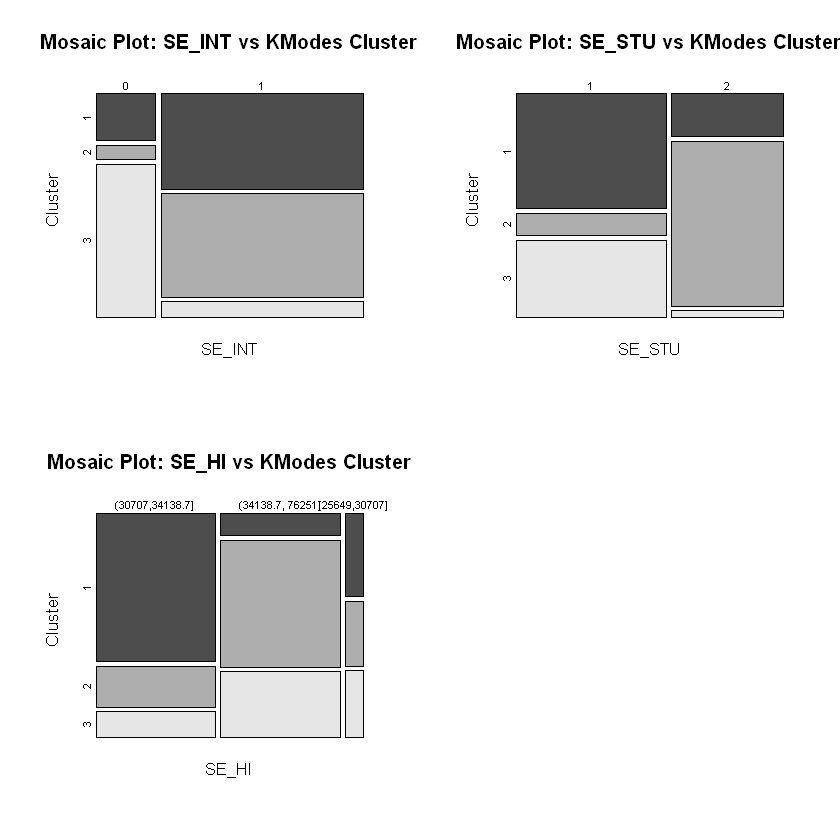

In [9]:
par(bg = "white", mfrow = c(2, 2))
# Mosaic plot for SE_INT vs cluster_kmodes
mosaicplot(table(se_vars$SE_INT, se_vars$cluster_kmodes),
           main = "Mosaic Plot: SE_INT vs KModes Cluster",
           xlab = "SE_INT", ylab = "Cluster", color = TRUE)
# Mosaic plot for SE_STU vs cluster_kmodes
mosaicplot(table(se_vars$SE_STU, se_vars$cluster_kmodes),
           main = "Mosaic Plot: SE_STU vs KModes Cluster",
           xlab = "SE_STU", ylab = "Cluster", color = TRUE)
# Mosaic plot for SE_HI vs cluster_kmodes
mosaicplot(table(se_vars$SE_HI, se_vars$cluster_kmodes),
           main = "Mosaic Plot: SE_HI vs KModes Cluster",
           xlab = "SE_HI", ylab = "Cluster", color = TRUE)

In [10]:
str(se_vars)

'data.frame':	2109 obs. of  4 variables:
 $ SE_INT        : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SE_STU        : Factor w/ 2 levels "1","2": 2 1 2 1 1 1 1 1 2 1 ...
 $ SE_HI         : Factor w/ 3 levels "(30707,34138.7]",..: 1 2 1 1 2 2 1 1 2 3 ...
 $ cluster_kmodes: Factor w/ 3 levels "1","2","3": 1 3 2 1 3 2 1 1 2 1 ...


In [11]:
# Add cluster_kmodes column to df
df$cluster_kmodes <- se_vars$cluster_kmodes
df$cluster_pam <- cluster_pam
str(df)

# Export to CSV
write.csv(df, "FINAL_DATASET_CLUSTERED.csv", row.names = FALSE)

'data.frame':	2109 obs. of  47 variables:
 $ ID            : int  1 2 3 4 5 6 10 12 13 17 ...
 $ MH_AGE        : chr  "[28,60]" "(71,93]" "[28,60]" "(60,71]" ...
 $ MH_SEX        : int  1 1 1 0 1 1 0 1 1 0 ...
 $ MH_OB         : int  1 1 0 0 1 0 0 0 0 1 ...
 $ MH_FHID       : int  0 0 0 1 0 1 1 1 0 0 ...
 $ MH_SMK        : int  1 3 1 3 2 1 3 1 2 1 ...
 $ MH_DM         : int  0 0 0 0 1 0 0 0 0 1 ...
 $ MH_HT         : int  1 1 0 0 1 1 1 0 0 1 ...
 $ MH_DLP        : int  1 0 0 1 1 1 0 1 1 0 ...
 $ MH_CKD        : int  0 0 0 0 0 0 0 0 NA 0 ...
 $ MH_PMI        : int  1 0 0 0 0 1 0 1 1 0 ...
 $ MH_PCS        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ MH_PPCI       : int  0 0 0 0 1 1 0 1 1 0 ...
 $ MH_PAD        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ MH_STK        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ MH_HMG        : int  2 2 2 2 1 1 2 1 1 2 ...
 $ SE_MS         : int  1 1 2 1 1 1 1 1 1 1 ...
 $ SE_SUP        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ SE_RES        : int  1 1 1 1 1 1 2 1 1 1 ...
 $ SE_STU        : in